<p>TODO:</p>
<ul>
    <li>Create single conda environment with all software used in analysis</li>
    <li>Create new filtered taxonomy artifact</li>
    <li>Make note of taxonomy-dropped sample, check corresponding metabolome</li>
    <li>Create a filtered metadata file with filtered samples removed</li>
    <li>Collapse metabolome tables if the table is present in both experiments</li>
    <li>Research metabolome analysis, come up with questions for help, look over previous analyses by Shiv</li>
</ul>

In [ ]:
# Clone the test-marm conda environment: https://stackoverflow.com/questions/42231764/how-can-i-rename-a-conda-environment
# Set up proper kernel for R

In [ ]:
import dokdo
import qiime2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import psutil
import re
import rpy2
import math
import requests


# This is a custom module with functions related to handling Qiime2 data
import q2Handler

# Qiime2 insists that you import all of its plugins by name, which is ridiculous.
# So this little bit of code imports all of the available qiime2 plugins. 
# If qiime2 is imported without Dokdo, the plugins module will have to be imported
# from qiime2 individually (a la 'from qiime2 import plugins')
for plugin in qiime2.plugins.available_plugins():
    qiime2.plugins.importlib.import_module(plugin)
    
%matplotlib inline
%load_ext rpy2.ipython
sns.set()

In [ ]:
### Global Variables ###
n_cores = len(psutil.Process().cpu_affinity())
baseDir = pathlib.Path('/common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome')
analysisDir = baseDir.joinpath('analysis')
artifactDir = analysisDir.joinpath('16S/q2_artifacts')
dataDir = baseDir.joinpath('data')

In [ ]:
### Sample Metadata Formatting and Processing ###
sampleMeta = pd.read_csv(dataDir.joinpath('metadata/metadata.tsv'), sep='\t', skiprows=[1])[['sample-id', 'individual', 'condition', 'date', 'cage', 'sex']]
sampleMeta.columns = sampleMeta.columns.str.capitalize()
sampleMeta = sampleMeta.rename(columns={'Sample-id': 'Sample_ID'}).astype(str)
sampleMeta[['Individual', 'Condition', 'Cage', 'Sex']] = sampleMeta[['Individual', 'Condition', 'Cage', 'Sex']].apply(lambda x: x.str.capitalize())
sampleMeta['Date'] = pd.to_datetime(sampleMeta['Date'])
sampleMeta.sort_values(by=['Individual', 'Date'], inplace=True)

# A Relative_Day column is created, which measures the time in days relative to the earliest date available for each individual
sampleMeta['Relative_Day'] = sampleMeta.apply((lambda x: (x['Date'] - sampleMeta.loc[sampleMeta['Individual'] == x['Individual']]['Date'].min()).days), axis=1)

# A new column is created that de-identifies marmosets (Names are changed to Marm_01, Marm_02, etc)
uniqueMarms = sampleMeta['Individual'].unique()
anonMarms = dict(zip(uniqueMarms, [str(num).zfill(math.floor(math.log10(uniqueMarms.shape[0])) + 1) for num in np.arange(1, uniqueMarms.shape[0]+1)]))
sampleMeta['Anon_Individual'] = sampleMeta['Individual'].apply(lambda x: 'Marm_{num}'.format(num=anonMarms.get(x)))

# A Qiime2-friendly metadata sheet is created and the sampleMeta dataframe is reindexed by Sample_ID
sampleMeta.rename(columns={'Sample_ID': 'sample-id'}).to_csv(analysisDir.joinpath('edited_metadata_and_manifests/qiime2_formatted_16s_metadata.tsv'), index=False, sep='\t')
sampleMeta.set_index('Sample_ID', inplace=True)

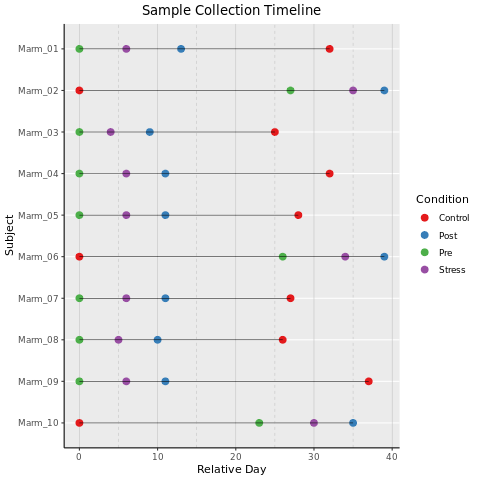

In [6]:
%%R -i sampleMeta
library('ggplot2')
library('forcats')
figureDir <- '/common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome/analysis/figures'

# A plot with collected samples and their time points is created
# Useful for creating themes:
# https://ggplot2.tidyverse.org/reference/theme.html
samplePlot <- ggplot(data=sampleMeta, aes(x=Relative_Day, y=fct_rev(Anon_Individual))) + 
    geom_point(aes(color=Condition), size=3) + geom_line(size=0.25) + 
    scale_color_brewer(palette='Set1') +
    theme(axis.line = element_line(color='black'),
    plot.background = element_rect(fill='white'),
    panel.grid.major.x = element_line(color = 'gray', size = 0.25),
    panel.grid.minor.x = element_line(color = 'gray', size = 0.25, linetype=2),
    panel.border = element_blank(),
    plot.title = element_text(hjust = 0.5),
    legend.key = element_blank()) +
    ylab('Subject') + xlab('Relative Day') + ggtitle('Sample Collection Timeline')
    
plot(samplePlot)
ggsave('sampleCollectionTimeline.pdf', plot=samplePlot, device='pdf', path=figureDir, width=5, height=5, units='in')

In [155]:
### Manifest Generation and Metadata Importing to Qiime2 ###
manifestDir = analysisDir.joinpath('edited_metadata_and_manifests')
q2Handler.manifestGen(metadataFile=manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), dataDir=dataDir, manifestDir=manifestDir, manifestStyle='python')
sample_metadata_md = qiime2.Metadata.load(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'))
manifestFile = manifestDir.joinpath('qiime2_formatted_16s_metadata_python_manifest')

### Sequence Importing ###
paired_end_seqs = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]', manifestFile, view_type='PairedEndFastqManifestPhred33')

demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=paired_end_seqs,
)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Adapters are trimmed and a visualization of the trimmed sequences is created
trimmed_seqs = qiime2.plugins.cutadapt.methods.trim_paired(
    demultiplexed_sequences=paired_end_seqs,
    cores=n_cores,
    front_f=["GTGCCAGCMGCCGCGGTAA"],
    front_r=["GGACTACHVGGGTWTCTAAT"],
    match_adapter_wildcards=True,
).trimmed_sequences

trimmed_demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=trimmed_seqs,
)

In [ ]:
##TODO: Figure out something to do with this##
q2Handler.qzvRender(trimmed_demux_viz)

In [ ]:
# Read quality visualization
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 10))
qzv_file = demux_viz
dokdo.read_quality_plot(qzv_file, strand='forward', ax=ax1)
dokdo.read_quality_plot(qzv_file, strand='reverse', ax=ax2)
ax1.set_title('Forward read')
ax2.set_title('Reverse read')
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.autoscale(enable=True, axis='x', tight=False)
plt.tight_layout()

In [157]:
### Denoising ###
# # If this gives a confusing error with a -9 exit code 
# # (meaning the process was stopped by the computer), it could be a memory issue.
# # Try increasing the RAM available to the cluster. 10 GB is a good place to start.
# # It seems like this (and maybe other) plugin(s) can't automatically detect the 
# # number of available cores, so that will have to be set automatically
table, rep_seqs, stats = qiime2.plugins.dada2.actions.denoise_paired(
    demultiplexed_seqs=trimmed_seqs,
    trim_left_f=5,
    trim_left_r=5,
    trunc_len_f=242,
    trunc_len_r=155,
    n_threads=n_cores,
)

# Denoising stats are summarized and saved below, along with
# FeatureTable[Frequency] (feature table) and FeatureData[Sequence] (representative sequences) artifacts.
stats_dada2_md_md = stats.view(qiime2.Metadata)

# Apparently the comma makes this a tuple, which I don't understand but okay
stats_viz, = qiime2.plugins.metadata.actions.tabulate(
    input=stats_dada2_md_md,
)

table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=table,
    sample_metadata=sample_metadata_md,
)
rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=rep_seqs,
)


Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_paired.R /tmp/tmpudgmrf_a/forward /tmp/tmpudgmrf_a/reverse /tmp/tmpudgmrf_a/output.tsv.biom /tmp/tmpudgmrf_a/track.tsv /tmp/tmpudgmrf_a/filt_f /tmp/tmpudgmrf_a/filt_r 242 155 5 5 2.0 2.0 2 12 independent consensus 1.0 8 1000000

R version 4.1.3 (2022-03-10) 


Loading required package: Rcpp


DADA2: 1.22.0 / Rcpp: 1.0.8.3 / RcppParallel: 5.1.5 
1) Filtering ........................................
2) Learning Error Rates
137598645 total bases in 580585 reads from 40 samples will be used for learning the error rates.
87087750 total bases in 580585 reads from 40 samples will be used for learning the error rates.
3) Denoise samples ........................................
........................................
4) Remove chimeras (method = consensus)
6) Write output


In [ ]:
### Denoising Stats ###
# Qiime2 Visualizations
q2Handler.qzvRender(stats_viz, sleepTime=60)
# q2Handler.qzvRender(table_viz, sleepTime=120)
# q2Handler.qzvRender(rep_seqs_viz, sleepTime=120)

<p>
    The whole taxonomy section is challenging to run on a jupyter notebook because all of the plugins involved
    tend to randomly crash. This is because they require a lot of RAM. Though a few tips for reducing RAM usage 
    are give below, the safest option is to run this cell with the maximum amount of memory available (62-64 GB RAM for Crane).
    If the notebook fails, try running the code with sbatch in a Slurm script instead.
</p>

In [158]:
### Taxonomy Analysis ###
fit_nb_classifier = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza'))

## Taxonomy Classification ##
# For this one, setting 'pre_dispatch' = '1' (string 1, not int 1) and reducing 'n_jobs' might help
taxonomy, = qiime2.plugins.feature_classifier.actions.classify_sklearn(
    classifier=fit_nb_classifier,
    reads=rep_seqs,
    n_jobs=(n_cores // 3),

)

taxonomy_as_md_md = taxonomy.view(qiime2.Metadata)
taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
   input=taxonomy_as_md_md,
)

taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
   table=table,
   taxonomy=taxonomy,
   metadata=sample_metadata_md,
)


<p>ASVs that are present in a single sample, or with a total abundance (across samples) < 10, and features classified as mitochondria, chloroplasts, or without genus-level annotation are removed at this step.</p>

In [163]:
## Filtering of feature table ##
# Features occuring artifactDironly one sample are removed
cont_freq_filter = qiime2.plugins.feature_table.methods.filter_features(
    table=table,
    min_samples=2,
)
# Mitochondrial and chloroplast taxa, and taxa without a genus, are removed
mc_table_filter = qiime2.plugins.taxa.methods.filter_table(
    table=cont_freq_filter.filtered_table,
    taxonomy=taxonomy,
    exclude='mitochondria,chloroplast',
    include='g__'
)

# Samples with < 1000 total reads (1075 and 877 in this case) are removed.
sample_table_filter = qiime2.plugins.feature_table.methods.filter_samples(
    table=mc_table_filter.filtered_table,
    min_frequency=1000,
    filter_empty_features=True,
)

filtered_table = sample_table_filter.filtered_table

## Sequence Table Filtering ##
# The sequence table is filtered according to the filtered feature table
seq_filter = qiime2.plugins.feature_table.methods.filter_seqs(
    data=rep_seqs,
    table=filtered_table,
)

filtered_rep_seqs = seq_filter.filtered_data

## Taxonomy Filtering ##
taxonomy_df = taxonomy.view(pd.DataFrame)
filtered_table_df = filtered_table.view(pd.DataFrame)

filtered_taxonomy = qiime2.Artifact.import_data(
    type='FeatureData[Taxonomy]', 
    view=taxonomy_df[taxonomy_df.index.isin(filtered_table_df.transpose().index)]
)

## Visualization ##
filtered_table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=filtered_table,
    sample_metadata=sample_metadata_md,
)

filtered_rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=filtered_rep_seqs,
)

filtered_taxonomy_as_md_md = filtered_taxonomy.view(qiime2.Metadata)
filtered_taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
   input=filtered_taxonomy_as_md_md,
)

filtered_taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
   table=filtered_table,
   taxonomy=filtered_taxonomy,
   metadata=sample_metadata_md,
)

In [160]:
### Saving Qiime2 Artifacts ###
paired_end_seqs.save(artifactDir.joinpath('paired-end-demux.qza').as_posix())
demux_viz.save(artifactDir.joinpath('paired-end-demux.qzv').as_posix())
trimmed_seqs.save(artifactDir.joinpath('trimmed-paired-end-demux.qza').as_posix())
trimmed_demux_viz.save(artifactDir.joinpath('trimmed-paired-end-demux.qzv').as_posix())
table.save(artifactDir.joinpath('table.qza').as_posix())
rep_seqs.save(artifactDir.joinpath('rep-seqs.qza').as_posix())
stats.save(artifactDir.joinpath('denoising-stats.qza').as_posix())
stats_viz.save(artifactDir.joinpath('denoising-stats.qzv').as_posix())
table_viz.save(artifactDir.joinpath('table.qzv').as_posix())
rep_seqs_viz.save(artifactDir.joinpath('rep-seqs.qzv').as_posix())
taxonomy.save(artifactDir.joinpath('taxonomy.qza').as_posix())
taxonomy_viz.save(artifactDir.joinpath('taxonomy.qzv').as_posix())
taxa_bar_plots_viz.save(artifactDir.joinpath('taxa-bar-plots.qzv').as_posix())
filtered_table.save(artifactDir.joinpath('filtered-table.qza').as_posix())
filtered_rep_seqs.save(artifactDir.joinpath('filtered-rep-seqs.qza').as_posix())
filtered_taxonomy.save(artifactDir.joinpath('filtered-taxonomy.qza').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxonomy.qzv').as_posix())
filtered_rep_seqs_viz.save(artifactDir.joinpath('filtered-rep-seqs.qzv').as_posix())
filtered_table_viz.save(artifactDir.joinpath('filtered-table.qzv').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxa-bar-plots.qzv').as_posix())

'/common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome/analysis/16S/q2_artifacts/filtered-taxa-bar-plots.qzv'

In [ ]:
%%capture --no-display
### Phylogenetic Tree Creation ###
action_results = qiime2.plugins.phylogeny.actions.align_to_tree_mafft_fasttree(
    sequences=filtered_rep_seqs,
    n_threads=n_cores,
)
aligned_rep_seqs = action_results.alignment
masked_aligned_rep_seqs = action_results.masked_alignment
unrooted_tree = action_results.tree
rooted_tree = action_results.rooted_tree


### Core Diversity Metrics (Phylogenetic) ###
diversity_action_results = qiime2.plugins.diversity.actions.core_metrics_phylogenetic(
    phylogeny=rooted_tree,
    table=filtered_table,
    sampling_depth=2000,
    metadata=sample_metadata_md,
    n_jobs_or_threads=n_cores,
)
rarefied_table = diversity_action_results.rarefied_table
faith_pd_vector = diversity_action_results.faith_pd_vector
observed_features_vector = diversity_action_results.observed_features_vector
shannon_vector = diversity_action_results.shannon_vector
evenness_vector = diversity_action_results.evenness_vector
unweighted_unifrac_pcoa_results = diversity_action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = diversity_action_results.weighted_unifrac_pcoa_results
jaccard_pcoa_results = diversity_action_results.jaccard_pcoa_results
bray_curtis_pcoa_results = diversity_action_results.bray_curtis_pcoa_results
bray_curtis_distance = diversity_action_results.bray_curtis_distance_matrix

aligned_rep_seqs.save(artifactDir.joinpath('alignment.qza').as_posix())
masked_aligned_rep_seqs.save(artifactDir.joinpath('masked_alignment.qza').as_posix())
unrooted_tree.save(artifactDir.joinpath('tree.qza').as_posix())
rooted_tree.save(artifactDir.joinpath('rooted_tree.qza').as_posix())
rarefied_table.save(artifactDir.joinpath('rarefied-table.qza').as_posix())
faith_pd_vector.save(artifactDir.joinpath('faith_pd_vector.qza').as_posix())
observed_features_vector.save(artifactDir.joinpath('observed_features_vector.qza').as_posix())
shannon_vector.save(artifactDir.joinpath('shannon_vector.qza').as_posix())
evenness_vector.save(artifactDir.joinpath('evenness_vector.qza').as_posix())
unweighted_unifrac_pcoa_results.save(artifactDir.joinpath('unweighted_unifrac_pcoa_results.qza').as_posix())
weighted_unifrac_pcoa_results.save(artifactDir.joinpath('weighted_unifrac_pcoa_results.qza').as_posix())
jaccard_pcoa_results.save(artifactDir.joinpath('jaccard_pcoa_results.qza').as_posix())
bray_curtis_pcoa_results.save(artifactDir.joinpath('bray_curtis_pcoa_results.qza').as_posix())
bray_curtis_distance.save(artifactDir.joinpath('bray_curtis_distance_matrix.qza').as_posix())

In [ ]:
### Taxonomy Visualization ###
# taxonomy_viz = qiime2.Visualization.load('python_analysis/taxonomy.qzv')
# qzv_file = 'python_analysis/taxa-bar-plots.qzv'
qzv_file = artifactDir.joinpath('no_stress/filtered-taxa-bar-plots.qzv')

## Taxonomy by sample name ##
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7), gridspec_kw={'width_ratios': [11, 1, 7]})
dokdo.taxa_abundance_bar_plot(
    qzv_file,
    ax=ax1,
    level=6,
    count=20,
    cmap_name='tab20',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    qzv_file,
    ax=ax2,
    level=6,
    count=20,
    cmap_name='tab20',
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

dokdo.taxa_abundance_box_plot(
    qzv_file,
    level=6,
    count=20,
    pretty_taxa=True,
    ax=ax3
)

plt.tight_layout()

## Taxonomy by individual (averaged) ##
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7), gridspec_kw={'width_ratios': [11, 1, 7]})
dokdo.taxa_abundance_bar_plot(
    qzv_file,
    ax=ax1,
    level=6,
    count=20,
    cmap_name='tab20',
    legend=False, 
    group='Individual'
)

dokdo.taxa_abundance_bar_plot(
    qzv_file,
    ax=ax2,
    level=6,
    count=20,
    cmap_name='tab20',
    legend_short=True,
    group='Individual'
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

dokdo.taxa_abundance_box_plot(
    qzv_file,
    level=6,
    count=20,
    pretty_taxa=True,
    ax=ax3
)

plt.tight_layout()

In [16]:
# Taxa are collapsed to relative genera abundance

collapsedTaxa = q2Handler.collapseTaxa(tableFile=artifactDir.joinpath('filtered-table.qza').as_posix(), taxonomyFile=artifactDir.joinpath('taxonomy.qza').as_posix())
genera_relative_abundance_table, = qiime2.plugins.feature_table.actions.relative_frequency(
    table=collapsedTaxa['level_6']
)

relativeGenera = genera_relative_abundance_table.view(pd.DataFrame).reset_index().rename(columns={'index': 'Sample_ID'})

# Missing samples in the filtered relativeGenera and relativeSpecies tables are replaced with 0
missingSamps = pd.Series(sampleMeta.loc[~sampleMeta.index.isin(relativeGenera['Sample_ID'])].index.values)
relativeGenera = relativeGenera.append(pd.DataFrame(np.full((len(missingSamps), len(relativeGenera.columns)), 0), columns=relativeGenera.columns))
relativeGenera['Sample_ID'] = pd.concat((relativeGenera['Sample_ID'][:-len(missingSamps)], missingSamps))

# The sample order in relativeGenera is matched to the sample metadata file
relativeGenera = relativeGenera.set_index('Sample_ID').loc[sampleMeta.index]

relativeGenera.to_csv(analysisDir.joinpath('16S/filtered_16s_relative_genera_abundance_stress.tsv'), index=True, na_rep='NaN', sep='\t')

In [ ]:
### Alpha and Beta Significance Testing ###
alpha_significance_faith_pd, = qiime2.plugins.diversity.visualizers.alpha_group_significance(
    alpha_diversity=faith_pd_vector,
    metadata=sample_metadata_md,
)

beta_significance_bray_curtis, = qiime2.plugins.diversity.visualizers.beta_group_significance(
    distance_matrix=bray_curtis_distance,
    metadata=sample_metadata_md.get_column('Condition'),
    pairwise=True,
    method='permanova'
)
beta_significance_bray_curtis.save(artifactDir.joinpath('beta-significance-bray-curtis.qzv').as_posix())
alpha_significance_faith_pd.save(artifactDir.joinpath('alpha-significance-faith-pd.qzv').as_posix())

In [166]:
# A lefse-formatted tsv file is created
sampleMeta[['Condition']].join(relativeGenera).T.to_csv(analysisDir.joinpath('16S/lefse/relative_genera_lefse_format.tsv'), index=True, na_rep='NaN', sep='\t', index_label='Sample_ID')

In [167]:
%%bash -s "$analysisDir/16S/lefse"
lefseDir=$1
lefse_format_input.py "${lefseDir}/relative_genera_lefse_format.tsv" "${lefseDir}/relative_genera_lefse.in" -c 2 -u 1
lefse_run.py "${lefseDir}/relative_genera_lefse.in" "${lefseDir}/relative_genera_lefse.res"
# This is empty because lefse reports no differentially abundant features
lefse_plot_res.py "${lefseDir}/relative_genera_lefse.res" "${lefseDir}/relative_genera_lefse.png"

Number of significantly discriminative features: 1 ( 1 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 0
No differentially abundant features found in /common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome/analysis/16S/lefse/relative_genera_lefse.res


In [11]:
### Metabolomics ###
# Dictionary mapping the column names of the targeted datasets to inchikey
metabColNameToInchikey = { 'αMA (ng/g)': 'DKPMWHFRUGMUKF-GDYCBZMLSA-N', 'βMA (ng/g)': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N',
    'βMA ': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N', 'ΩMA': 'DKPMWHFRUGMUKF-NTPBNISXSA-N', 'ΩMA ': 'DKPMWHFRUGMUKF-NTPBNISXSA-N',
    'CA (ng/g)': 'BHQCQFFYRZLCQQ-OELDTZBJSA-N', 'HCA (ng/g)': 'DKPMWHFRUGMUKF-KWXDGCAGSA-N', 'LCA (µg/g)': 'SMEROWZSTRWXGI-HVATVPOCSA-N',
    'CDCA (µg/g)': 'RUDATBOHQWOJDD-BSWAIDMHSA-N', 'DCA (µg/g)': 'KXGVEGMKQFWNSR-LLQZFEROSA-N', 'GCA (ng/g)': 'RFDAIACWWDREDC-FRVQLJSFSA-N',
    'GCDCA (ng/g)': 'GHCZAUBVMUEKKP-GYPHWSFCSA-N', 'GDCA (ng/g)': 'WVULKSPCQVQLCU-BUXLTGKBSA-N', 'GLCA (ng/g)': 'XBSQTYHEGZTYJE-OETIFKLTSA-N',
    'TCA (ng/g)': 'WBWWGRHZICKQGZ-HZAMXZRMSA-N', 'TCDCA (ng/g)': 'BHTRKEVKTKCXOH-BJLOMENOSA-N', 'TLCA (ng/g)': 'QBYUNVOYXHFVKC-GBURMNQMSA-N',
    'TDCA (ng/g)': 'AWDRATDZQPNJFN-VAYUFCLWSA-N', 'HyPro': 'PMMYEEVYMWASQN-DMTCNVIQSA-N', 'His': 'HNDVDQJCIGZPNO-YFKPBYRVSA-N',
    'Asn': 'DCXYFEDJOCDNAF-REOHCLBHSA-N', 'Tau': 'XOAAWQZATWQOTB-UHFFFAOYSA-N', 'Ser': 'MTCFGRXMJLQNBG-REOHCLBHSA-N',
    'Gln': 'ZDXPYRJPNDTMRX-VKHMYHEASA-N', 'Arg': 'ODKSFYDXXFIFQN-BYPYZUCNSA-N', 'Gly': 'DHMQDGOQFOQNFH-UHFFFAOYSA-N',
    'Asp': 'CKLJMWTZIZZHCS-REOHCLBHSA-N', 'Thr': 'AYFVYJQAPQTCCC-GBXIJSLDSA-N', 'Ala': 'QNAYBMKLOCPYGJ-REOHCLBHSA-N', 
    'GABA': 'BTCSSZJGUNDROE-UHFFFAOYSA-N', 'Pro': 'ONIBWKKTOPOVIA-BYPYZUCNSA-N', 'Orn': 'AHLPHDHHMVZTML-BYPYZUCNSA-N',
    'Cys': 'XUJNEKJLAYXESH-REOHCLBHSA-N', 'Cys2': 'LEVWYRKDKASIDU-IMJSIDKUSA-N', 'Lys': 'KDXKERNSBIXSRK-YFKPBYRVSA-N',
    'Tyr': 'OUYCCCASQSFEME-QMMMGPOBSA-N', 'Met': 'FFEARJCKVFRZRR-BYPYZUCNSA-N', 'Val': 'KZSNJWFQEVHDMF-BYPYZUCNSA-N', 
    'Ile': 'AGPKZVBTJJNPAG-WHFBIAKZSA-N', 'Leu': 'ROHFNLRQFUQHCH-YFKPBYRVSA-N', 'Phe': 'COLNVLDHVKWLRT-QMMMGPOBSA-N',
    'Trp': 'QIVBCDIJIAJPQS-VIFPVBQESA-N', 'Glu': 'WHUUTDBJXJRKMK-VKHMYHEASA-N', 'Acetic acid': 'QTBSBXVTEAMEQO-UHFFFAOYSA-N', 
    'Propionic acid': 'XBDQKXXYIPTUBI-UHFFFAOYSA-N', 'Butyric acid': 'FERIUCNNQQJTOY-UHFFFAOYSA-N',
    'Isovaleric acid': 'GWYFCOCPABKNJV-UHFFFAOYSA-N', 'Valeric acid': 'NQPDZGIKBAWPEJ-UHFFFAOYSA-N'
}

# Dictionaries mapping the inchikey to a tuple with: 
#the PubChem CID (0), common name (1), and molecular formula (2)
metabInchikeyToProperties = {}
# Initial data and metadata are read. The scfa columns measured in "Concentration in µmol/g" are dropped, as they are also measured in mg/g
bileAcids = pd.DataFrame(pd.read_excel(dataDir.joinpath('metabolomics/SH_BileAcid_Report_20210222.xlsx'), engine='openpyxl'))
faa = pd.DataFrame(pd.read_excel(dataDir.joinpath('metabolomics/SH_FAA_Report_20210114.xlsx'), engine='openpyxl')).iloc[:-2, :27]
scfa = pd.DataFrame(pd.read_excel(dataDir.joinpath('metabolomics/SH_SCFAs_Report_20210706_Corrected_20220128.xlsx'), engine='openpyxl', header=1)).iloc[:, :5]

# Duplicate metabolites are removed from the faa dataset according to collaborator's input
faa = faa.drop(columns='Tyr').rename(columns={'Tyr.1': 'Tyr'})

In [12]:
# The API is pretty confusing and doesn't allow searching multiple common names at once,
# which is why this whole complicated schema had to be used. The only other alternative
# was to figure out the more complicated PUG or PUG SOAP APIs, which might be a smarter
# investment in the future.

prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/'
inputs = '/compound/inchikey/'
operation = '/property/inchikey,title,molecularformula,iupacname'
output = '/JSON'
headers = {
    'Content-Type': "application/x-www-form-urlencoded",
}
# Inchikeys from all datasets are combined and queried against the PubChem database
payload = {'inchikey': ','.join(list(metabColNameToInchikey.values()))}

response = requests.request(
    method='POST', 
    url=prolog + inputs + operation + output,
    data=payload,
    headers=headers
)
# Results are written to the metabInchikeyToProperties dict
for record in response.json()['PropertyTable']['Properties']:
    metabInchikeyToProperties.update({record['InChIKey']: [str(record['CID']), record['Title'], record['MolecularFormula'], record['IUPACName']]})

In [13]:
### Metabolite and Taxonomy Processing ###
## Columns are renamed to allow easier indexing
for df in (bileAcids, faa, scfa):
    df.rename(columns={df.columns[0] : 'Sample_ID'}, inplace=True)
    df.rename(columns=metabColNameToInchikey, inplace=True)
    df['Sample_ID'] = df['Sample_ID'].astype(int)
    

# As the targeted metabolites are quantified in different units, they are converted to a common unit (ug/g)
scfa.iloc[:, 1:] = scfa.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') * 1000
ngCols = bileAcids.loc[:, ~bileAcids.columns.isin(['SMEROWZSTRWXGI-HVATVPOCSA-N','RUDATBOHQWOJDD-BSWAIDMHSA-N','KXGVEGMKQFWNSR-LLQZFEROSA-N'])].copy()
ngCols.iloc[:, 1:] = ngCols.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') / 1000
bileAcids.loc[:, bileAcids.columns.isin(ngCols.columns)] = ngCols

# Metabolites are combined into one dataframe
targetedMetab = scfa.merge(bileAcids, on='Sample_ID').merge(faa, on='Sample_ID').replace(('ND', 0.0), np.NaN)
targetedMetab['Sample_ID'] = targetedMetab['Sample_ID'].astype(str)

# Targeted feature metadata is created
targetedFeatureMeta = {'INCHIKEY': [], 'CID': [], 'Metabolite name': [], 'Formula': [], 'IUPACName': [], 'Method': [], 'Dataset': []}
for tup in ((scfa.columns[1:], 'GC-MS', 'short_chain_fatty_acids'), (bileAcids.columns[1:], 'LC-MS', 'bile_acids'), (faa.columns[1:], 'HPLC', 'amino_acids')):
    for key, value in ((col, metabInchikeyToProperties.get(col)) for col in tup[0]):
        targetedFeatureMeta['INCHIKEY'].append(key)
        targetedFeatureMeta['CID'].append(value[0])
        targetedFeatureMeta['Metabolite name'].append(value[1])
        targetedFeatureMeta['Formula'].append(value[2])
        targetedFeatureMeta['IUPACName'].append(value[3])
        targetedFeatureMeta['Method'].append(tup[1])
        targetedFeatureMeta['Dataset'].append(tup[2])
targetedFeatureMeta = pd.DataFrame(targetedFeatureMeta).T.reset_index()
targetedFeatureMeta.columns = np.concatenate([['Sample_ID'], targetedFeatureMeta.iloc[0, 1:].values])

# The sample_id column is used as a uniting index for all of the dataframes
for df in (targetedMetab, targetedFeatureMeta):
    df.set_index('Sample_ID', inplace=True)

# The samples are reordered in each dataframe to match the order in the sample metadata
targetedMetab = targetedMetab.loc[sampleMeta.index, :]

In [14]:
### Filtering and Feature Scaling ###
# Features with more than 70% missing values are dropped, and remaining missing values are replaced with the median
# as recommended by: https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/elps.201500352
targetedMetab.drop(columns=targetedMetab.loc[:, (targetedMetab.isna().sum() / targetedMetab.shape[0]) > .70].columns, inplace=True)

# Metabolite datasets are scaled by the median so that each feature has a median of 1
metabScaled = (targetedMetab.fillna(targetedMetab.median(), axis=0) / targetedMetab.median(axis=0)).dropna(axis=1)

# Median-scaled values are used for the rest of the analysis
# targetedMetab = metabScaled

# Metabolite metadata is updated to remove dropped metabolites
targetedFeatureMeta = targetedFeatureMeta[metabScaled.columns]

In [20]:
%%R
### Various R Functions ###
convertDF <- function(df, meta) {
    dfDat <- list(x=df, metaS=as.data.frame(lapply(meta[rownames(df), ], as.factor)))
    rownames(dfDat$metaS) <- rownames(meta)
    return(dfDat)
}

# This function calculates the bray-curtis dissimilarity matrix for a dataset and runs a PERMANOVA for between- and within-subject factors
# It could probably be improved, but for now this is okay. The PERMANOVA does 10000 permutations. Here are good sources for learning more:
# https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/permanova/
# https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/restricting-permutations/
runPerm <- function(df) {
    library('vegan')
    library('labdsv')
    D <- dsvdis(df$x, index="bray/curtis")
    within_perm <- how(nperm=9999, blocks=df$metaS$Individual, within=Within(type='free'), plots = Plots(type = "none"), observed=TRUE)
    bet_perm <- how(nperm=9999, within=Within(type='none'), plots=Plots(strata=df$metaS$Individual, type='free'), observed=TRUE)
    withinRes <- adonis2(D ~ Individual + Condition, data=df$metaS, permutation=within_perm)
    betRes <- adonis2(D ~ Sex + Cage + Individual, data=df$metaS, permutation=bet_perm)
    return(list(betRes, withinRes))
}

# Calculates bray-curtis distance (optional) and performs a PCoA
PCoA <- function(dat, D=NA, k=2) {
    library('vegan')
    library('labdsv')
    x <- dat$x
    k <- max(k, 2)
    D <- dsvdis(x, index="bray/curtis")
    pc <- pco(D, k)
    ord <- pc
    toteig <- sum(pc$eig[pc$eig>0])
    ord$ordnames <- sprintf("PCo %d (%0.1f%%)", 1:k, 100 * pc$eig[1:k] / toteig)
    return (ord)
}

ordplot <- function(dat, ord, pcos = 2, pointoutline = T,
        colour = NA, colour_title = NA, colour_names = NA, colour_override = NA,
        shape = NA,  shape_title = NA,  shape_names = NA,  shape_override = NA,
        size = NA, size_title = NA, size_names = NA, size_override = NA,
        size_abs = NA, outline_size = NA,
        surface = NA, surf_maj_lines = 8, surf_min_lines = 4, surf_extent = 1,
        surf_smoothness = 1, surf_quality = 100,
        centroid = NA, loading = NA, sigloadings = NA,
        enriched = NA, text_halo = T,
        colour_log = F, colour_log_pseudocount = 0, colour_log_base = 10,
        arrows_fixed = NULL, arrows = NULL, arrow_text = T, arrow_sqrtnorm = T,
        connect = NA, sequence = NA, connectwidth = NA, sortby = NA, decreasing = F) {

    library('ggplot2')
    library('ggpubr')
    # ggplot2-based function to visualize the results of an ordination
    dat$meta <- dat$metaS
    
    

    # Set up the plot
    ggp <- ggplot() + theme_classic() +
        theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())
    gptopt <- list()
    gptaes <- list(x="dim1", y="dim2")

    # Get the dimensions to plot, and set the axes appropriately
    if (length(pcos) == 1) {
        pcos <- max(pcos,2)
        pcos <- c(pcos-1, pcos)
    } else {
        stopifnot(length(pcos) == 2)
    }
    stopifnot(max(pcos) <= dim(ord$points)[2])
    pts <- as.data.frame(ord$points[,pcos])
    if (is.null(ord$ordnames)) {
        dims <- colnames(pts)
    } else {
        dims <- ord$ordnames[pcos]
    }
    colnames(pts) <- c("dim1", "dim2")
    ggp <- ggp + xlab(dims[1]) + ylab(dims[2])

    # Use this mapping to allow the ordination to be done on a subset of the
    # data without requiring that dat also be that subset
    metamatch <- match(rownames(pts), rownames(dat$x))
    if (any(is.na(metamatch))) {
        pts <- pts[!is.na(metamatch),]
        metamatch <- metamatch[!is.na(metamatch)]
    }

    getmeta <- function(name) {
        tgt <- name == colnames(dat$meta)
        if (any(tgt)) {
            return (dat$meta[metamatch,tgt])
        }
        tgt <- name == colnames(dat$x)
        if (any(tgt)) {
            return (dat$x[metamatch,min(which(tgt))])
        }

        stop(sprintf("%s is not a metadata or feature.", name))
    }

    # Apply sorting
    if (!is.na(sortby)) {
        s <- getmeta(sortby)
        pts <- pts[order(s, decreasing=decreasing),]
        metamatch <- match(rownames(pts), rownames(dat$x))
    }

    # Draw connectors first
    if (!is.na(connect) || !is.na(sequence)) {
        df <- data.frame(x=pts$dim1, y=pts$dim2)

        if (!is.na(connect)) {
            connectby <- getmeta(connect)
            df$group <- connectby
        }
        if (!is.na(sequence)) {
            seqby <- getmeta(sequence)
            df <- df[order(seqby),]
        }
        if (!is.na(connect)) {
            ggp <- ggp + geom_path(data=df, aes(x=x, y=y, group=group), size=ifelse(is.na(connectwidth), 1, connectwidth))
        } else {
            ggp <- ggp + geom_path(data=df, aes(x=x, y=y), size=ifelse(is.na(connectwidth), 1, connectwidth))
        }
    }

    # Draw the surface
    if (!is.na(surface)) {
        surfby <- getmeta(surface)

        # pick an appropriate bandwidth
        bw1 <- surf_smoothness * 1.06 * sd(pts$dim1) * length(pts$dim1)^-0.2
        bw2 <- surf_smoothness * 1.06 * sd(pts$dim2) * length(pts$dim2)^-0.2

        library(signal) # for unwrap

        # only make the surface from finite values
        keep <- !is.na(surfby) & is.finite(surfby)
        surfby <- surfby[keep]
        xp <- pts$dim1[keep]
        yp <- pts$dim2[keep]

        # distance from the points to draw
        extent <- 0.5 * surf_extent^2 / surf_smoothness

        # surface from a Gaussian weighted mean
        gkmeansurf <- function(x, y) {
            dx <- x - xp
            dy <- y - yp
            chi2 <- (dx / bw1)^2 + (dy / bw2)^2
            kern <- exp(-chi2)

            theta <- unwrap(atan2(dy, dx))
            mnchi2 <- min(chi2)
            if (mnchi2 > extent && (max(theta) - min(theta)) < pi) { return (NA) }

            return (-sum(surfby * kern) / sum(kern))
        }

        # drop a grid on the ordination
        n <- surf_quality + 1
        border <- surf_extent
        xx <- matrix(seq(from=min(pts$dim1) - border * bw1,
                         to  =max(pts$dim1) + border * bw1,
                         length=n), n, n, byrow=F)
        yy <- matrix(seq(from=min(pts$dim2) - border * bw2,
                         to  =max(pts$dim2) + border * bw2,
                         length=n), n, n, byrow=T)

        # measure the surface at all points
        z <- mapply(gkmeansurf, as.vector(xx), as.vector(yy))

        # only keep points in range
        keep <- !is.na(z)

        # plot contours
        zrange <- max(z[keep]) - min(z[keep])
        cdata <- data.frame(x=as.vector(xx)[keep], y=as.vector(yy)[keep], z=z[keep])
        ggp <- ggp + stat_contour(aes(x=x, y=y, z=z), data=cdata,
               size=0.5, colour="grey50", binwidth=zrange/(surf_maj_lines*(surf_min_lines+1)))
        ggp <- ggp + stat_contour(aes(x=x, y=y, z=z), data=cdata,
               size=1, colour="black", binwidth=zrange/surf_maj_lines)
    }

    # Set up the plot to shape by some metadata
    if (!is.na(shape)) {
        shapeby <- getmeta(shape)
        if (length(shape_names) > 1 || !is.na(shape_names)) {
            # reorder the factors to match the order in shape_names
            # so that the legend is displayed in the correct order
            shapeby <- factor(levels(shapeby)[as.numeric(shapeby)],
                              levels=names(shape_names))
        }
        pts$shape <- shapeby
        gptaes$shape <- "shape"
        if (is.na(shape_title)) {
            shape_title <- shape
        }

        ggp <- ggp + guides(shape = guide_legend(title = shape_title,
                                                 override.aes = list(size=4, fill="gray")))

        if (length(shape_override) > 1 || !is.na(shape_override)) {
            # User-defined shapes
            if (length(shape_names) == 1 && is.na(shape_names)) {
                shape_names <- shape_override
                shape_names[names(shape_override)] <- names(shape_override)
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shape_override),
                                            breaks=names(shape_names),
                                            labels=unlist(shape_names))
        } else if (pointoutline) {
            # Automatic shapes - select the "fillable" ones
            shps <- list()
            shapeby <- factor(shapeby)
            for (i in 1:length(levels(shapeby))) {
                shps[[levels(shapeby)[i]]] <- 20+i
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shps))
        } else {
            # Automatic shapes - no outlines
            shps <- list()
            shapeby <- factor(shapeby)
            for (i in 1:length(levels(shapeby))) {
                shps[[levels(shapeby)[i]]] <- 15+i
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shps))
        }

    } else if (length(shape_override) == 1 && !is.na(shape_override)) {
        gptopt$shape <- shape_override
    } else {
        gptopt$shape <- if (pointoutline) {21} else {19}
    }

    # Set up the plot to size by some metadata
    if (!is.na(size)) {
        sizeby <- getmeta(size)

        gptaes$size <- "size"
        if (is.na(size_title)) {
            size_title <- size
        }

        if (is.numeric(sizeby)) {
            if (!is.na(size_abs)) {
                sizeby <- sizeby * size_abs
            }
        } else if (length(size_override) > 1 || !is.na(size_override)) {
            # User-defined shapes
            if (length(size_names) == 1 && is.na(size_names)) {
                size_names <- size_override
                size_names[names(size_override)] <- names(size_override)
            }
            ggp <- ggp + scale_size_manual(values=unlist(size_override),
                                            breaks=names(size_names),
                                            labels=unlist(size_names))
        }

        pts$size <- sizeby
        ggp <- ggp + guides(size = guide_legend(title = size_title))
    } else {
        if (is.na(size_abs)) {
            gptopt$size <- min(6, 50 / sqrt(length(metamatch)))
        } else {
            gptopt$size <- size_abs
        }
    }

    # Set up the plot to colour based on metadata
    if (pointoutline) {
        ggscale_manual <- scale_fill_manual
        ggscale_gradientn <- scale_fill_gradientn
        ggscale_brewer <- scale_fill_brewer
        ggcolorfield <- "fill"
        if (!is.na(outline_size)) {
            gptopt[["stroke"]] <- outline_size
        }
    } else {
        ggscale_manual <- scale_colour_manual
        ggscale_gradientn <- scale_colour_gradientn
        ggscale_brewer <- scale_colour_brewer
        ggcolorfield <- "colour"
    }
    if (!is.na(colour)) {
        colby <- getmeta(colour)
        if (length(colour_names) > 1 || !is.na(colour_names)) {
            # reorder the factors to match the order in colour_names
            # so that the legend is displayed in the correct order
            colby <- factor(as.character(colby),
                            levels=names(colour_names))
        }
        if (is.numeric(colby) && colour_log) {
            colby <- log(colby + colour_log_pseudocount, base=colour_log_base)
        }
        pts$colour <- colby
        gptaes[[ggcolorfield]] <- "colour"

        if (is.na(colour_title)) {
            colour_title <- colour
        }

        if (length(colour_override) > 1 || !is.na(colour_override)) {
            # Manual colouring
            if (length(colour_names) == 1 && is.na(colour_names)) {
                colour_names <- colour_override
                colour_names[names(colour_override)] <- names(colour_override)
            }
            if (is.numeric(colby)) {
                ggp <- ggp + ggscale_gradientn(colours = colour_override, na.value="grey80")
            } else {
                ggp <- ggp + ggscale_manual(values=unlist(colour_override),
                                            breaks=names(colour_names),
                                            labels=unlist(colour_names))
            }
            col_guide <- guide_legend(title = colour_title,
                                      override.aes = list(size=3, shape=21))
        } else if (is.numeric(colby)) {
            # Continuous data uses the RdYlGn palette
            #library(RColorBrewer)
            #ggp <- ggp + ggscale_gradientn(colours = colorRampPalette(c("dodgerblue","goldenrod1","firebrick"))(100))
            library(viridis)
            ggp <- ggp + ggscale_gradientn(colours = viridis(100), na.value="grey80")
                   #brewer.pal(n = 11, name = "YlGnBu"))
            #ggp <- ggp + ggscale_gradientn(colours = rev(brewer.pal(n = 11, name = "RdYlGn")))
            col_guide <- guide_colourbar(title = colour_title)
        } else if (length(levels(colby)) > 9) {
            library(RColorBrewer)
            ggp <- ggp + ggscale_manual(values = colorRampPalette(
                rev(brewer.pal(n = 7, name = "RdYlBu")))(length(levels(colby))))
            col_guide <- guide_legend(title = colour_title,
                                    override.aes = list(size=3, shape=21))
        } else {
            # Discrete data uses the Set1 palette
            ggp <- ggp + scale_fill_brewer(palette = "Set1")
            col_guide <- guide_legend(title = colour_title,
                                override.aes = list(size=3, shape=21))
        }
        if (pointoutline) {
            ggp <- ggp + guides(fill = col_guide)
        } else {
            ggp <- ggp + guides(colour = col_guide)
        }
    } else if (length(colour_override) == 1 && !is.na(colour_override)) {
        gptopt[[ggcolorfield]] <- colour_override
    } else {
        gptopt[[ggcolorfield]] <- "darkslategray4"
    }

    # Draw the points
    gptopt$data <- pts
    gptopt <- c(list(do.call(aes_string, gptaes)), gptopt)
    ggp <- ggp + do.call(geom_point, gptopt)

    # Helper to add text annotations
    xr <- 0.0018
    dx <- xr * (max(pts[,1]) - min(pts[,1]))
    dy <- 1.1 * xr * (max(pts[,2]) - min(pts[,2]))
    halo_quality <- 12
    put_text <- function(x, y, text, ...) {
        if (text_halo) {
            phi <- 2 * pi / halo_quality
            for (i in 1:halo_quality) {
                ggp <<- ggp + annotate("text", label=text, color="white",
                                       x = x + dx*cos((i - 0.5) * phi),
                                       y = y + dy*sin((i - 0.5) * phi), ...)
            }
        }
        ggp <<- ggp + annotate("text", label=text, x=x, y=y, ..., color="black")
    }

    # Add metadata centroids
    if (length(centroid) > 1 || !is.na(centroid)) {
        for (i in seq_along(centroid)) {
            meta <- getmeta(centroid[i])

            if (is.numeric(meta)) {
                d1 <- sum(pts$dim1 * meta) / sum(meta)
                d2 <- sum(pts$dim2 * meta) / sum(meta)
                put_text(d1, d2, centroid[i])
            } else {
                meta <- factor(meta) # remove unused
                for (j in seq_along(levels(meta))) {
                    d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                    d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                    put_text(d1, d2, levels(meta)[j])
                }
            }
        }
    }

    # Add metadata enrichment modes
    if (length(enriched) > 1 || !is.na(enriched)) {
        library("neldermead")
        for (i in seq_along(enriched)) {
            meta <- getmeta(enriched[i])

            if (!is.numeric(meta)) {
                stop(sprintf("%s must be numeric to find its enrichment mode"))
            }

            # select appropriate bandwidths
            bw1 <- 1.06 * sd(pts$dim1) * length(pts$dim1)^-0.2
            bw2 <- 1.06 * sd(pts$dim2) * length(pts$dim2)^-0.2

            # only use finite values
            keep <- !is.na(meta) & is.finite(meta)
            meta <- meta[keep]
            xp <- pts$dim1[keep]
            yp <- pts$dim2[keep]

            enr <- function(xy) {
                chi2 <- ((xy[1] - xp) / bw1)^2 + ((xy[2] - yp) / bw2)^2
                kern <- exp(-chi2)
                nsamps <- sum(kern)
                modulator <- nsamps / (nsamps + 1)
                return (modulator * -sum(meta * kern) / sum(kern))
            }

            bestxy <- 0
            bestnenr <- Inf
            for (x0 in seq(from=min(pts$dim1), to=max(pts$dim1), length=5)) {
                for (y0 in seq(from=min(pts$dim2), to=max(pts$dim2), length=5)) {
                    res <- fminsearch(enr, c(x0, y0))
                    if (neldermead.get(res, "fopt") < bestnenr) {
                        bestxy <- neldermead.get(res, "xopt")
                        bestnenr <- neldermead.get(res, "fopt")
                    }
                }
            }

            put_text(bestxy[1], bestxy[2], enriched[i])
        }
    }

    # Add arrows
    if (!is.null(arrows) || !is.null(arrows_fixed)) {
        if (is.null(arrows_fixed)) {
            arr_pcos <- matrix(0, 0, 2, dimnames=list(c(), dims))
        } else {
            arr_pcos <- arrows_fixed[,pcos]
        }
        if (!is.null(arrows)) {
            if (is.numeric(arrows)) {
                arrSet <- c()
                feats <- c(colnames(dat$x))
                for (i in seq_along(feats)) {
                    meta <- getmeta(feats[i])

                    if (is.numeric(meta)) {
                        d1 <- sum(pts$dim1 * meta) / sum(meta)
                        d2 <- sum(pts$dim2 * meta) / sum(meta)
                        arr <- matrix(c(d1, d2), 1, 2)
                        rownames(arr) <- feats[i]
                        arrSet <- rbind(arrSet, arr)
                    } else {
                        meta <- factor(meta) # remove unused
                        for (j in seq_along(levels(meta))) {
                            d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                            d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                            arr <- matrix(c(d1, d2), 1, 2)
                            rownames(arr) <- levels(meta)[j]
                            arrSet <- rbind(arrSet, arr)
                        }
                    }
                }
                arrSz <- arrSet[,1]^2 + arrSet[,2]^2
                I <- order(-arrSz)
                arr_pcos <- rbind(arr_pcos, arrSet[I[1:arrows],])
            } else {
                for (i in seq_along(arrows)) {
                    meta <- getmeta(arrows[i])

                    if (is.numeric(meta)) {
                        d1 <- sum(pts$dim1 * meta) / sum(meta)
                        d2 <- sum(pts$dim2 * meta) / sum(meta)
                        arr <- matrix(c(d1, d2), 1, 2)
                        rownames(arr) <- arrows[i]
                        arr_pcos <- rbind(arr_pcos, arr)
                    } else {
                        meta <- factor(meta) # remove unused
                        for (j in seq_along(levels(meta))) {
                            d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                            d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                            arr <- matrix(c(d1, d2), 1, 2)
                            rownames(arr) <- levels(meta)[j]
                            arr_pcos <- rbind(arr_pcos, arr)
                        }
                    }
                }
            }
        }

        ptsRS <- rowSums(pts[,1:2]^2)
        maxRadius <- sqrt(max(ptsRS[is.finite(ptsRS)]))
        maxArrRadius <- sqrt(max(rowSums(arr_pcos^2)))
        arr_pcos <- arr_pcos * (0.85 * maxRadius / maxArrRadius)
        if (arrow_sqrtnorm) {
            arr_len <- sqrt(rowSums(arr_pcos^2))
            maxarr_len <- max(arr_len)
            narr_len <- maxarr_len * sqrt(arr_len / maxarr_len)
            arr_pcos <- arr_pcos * (narr_len / arr_len)
        }
        colnames(arr_pcos) <- paste("dim", 1:length(pcos), sep="")

        ggp <- ggp + geom_segment(data=as.data.frame(arr_pcos),
                                  aes(x=0, y=0, xend=dim1, yend=dim2),
                                  colour="red", arrow=arrow())

        if (arrow_text) {
            for (i in seq_len(nrow(arr_pcos))) {
                rr <- arr_pcos[i,]
                hjust <- 0.5
                vjust <- 0.5
                if (abs(rr[1]) > abs(rr[2])) {
                    hjust <- if (rr[1] > 0) {0} else {1}
                } else {
                    vjust <- if (rr[2] > 0) {0} else {1}
                }
                tc <- rr * (1 + 0.015 * maxRadius / sqrt(sum(rr^2)))
                put_text(tc[1], tc[2], rownames(arr_pcos)[i],
                         hjust=hjust, vjust=vjust, color='red')
            }
        }
    }

    return (ggp)
}

# This function fits a linear mixed model to the data and extracts the pearson residuals for downstream analysis.
# It is based on this article: https://doi.org/10.1038/s41586-019-1237-9, and the purpose of residualization
# is to remove all variance from the feautres except for the variance caused by time (relative_day in the metadata).
# Downstream correlation analysis with halla then treats any significant correlation between features as an association over time.

# In other words, the goal of this model was to minimize inter-individual variation while maximizing intra-individual variation
# in the hopes that temporal associations between and within feature types could be analyzed. There are better ways to analyze longitudinal data,
# but this was the best solution I could find given the ad hoc nature of this study.
## The "str" and "names" functions in R are crucial for figuring out how to extract things from the model!!!
runMixedModel <- function(df) {
    library('lme4')
    library('lmerTest')
    
    # Residual matrix is created
    resid <- matrix(NA, nrow(df$x), ncol(df$x))
    rownames(resid) <- rownames(df$x)
    colnames(resid) <- colnames(df$x)
    
    # A dataframe of p-value is created
    sig <- data.frame('Feature_Name'=colnames(df$x))
    sig$pvaluePre <- NA
    sig$pvalueStress <- NA
    sig$pvaluePost <- NA

    for (i in seq_along(colnames(df$x))) {
        y <- df$x[rownames(df$metaS),i]

        mdl <- suppressMessages(lmer((y ~ Condition + Sex + (1 | Individual)), data=df$metaS, REML=TRUE))
        # mdl2 <- lm((y ~ Condition + Sex + Individual), data=df$metaS)

        sig$pvaluePre[i] <- summary(mdl)$coefficients['ConditionPre', 'Pr(>|t|)']
        sig$pvalueStress[i] <- summary(mdl)$coefficients['ConditionStress', 'Pr(>|t|)']
        sig$pvaluePost[i] <- summary(mdl)$coefficients['ConditionPost', 'Pr(>|t|)']
        
        # # Save full residuals for downstream analysis
        r <- residuals(mdl, type="pearson")
        resid[names(r),i] <- r

    }
    sig$qvaluePre <- p.adjust(sig$pvaluePre, 'fdr')
    sig$qvalueStress <- p.adjust(sig$pvalueStress, 'fdr')
    sig$qvaluePost <- p.adjust(sig$pvaluePost, 'fdr')
    rownames(sig) <- sig$Feature_Name
    sig <- sig[,-1]
    resid <- as.data.frame(resid)
    result <- list(sig=sig, res=resid)
    return(result)
}

# This is essentially the same function as the runMixedModel function, but it only uses a normal fixed-effects model
# (because the number of replicates per individual is too small to run a mixed model)
# and it extracts residuals without differential feature testing
runFixedModel <- function(df) {
    library('lme4')
    # Allocate output matrix
    resid <- matrix(NA, nrow(df$x), ncol(df$x))
    rownames(resid) <- rownames(df$x)
    colnames(resid) <- colnames(df$x)
    
    for (i in seq_along(colnames(df$x))) {
        y <- df$x[rownames(df$metaS),i]

        mdl <- lm((y ~ Individual + Sex + Cage), data=df$metaS)

        # Save full residuals for downstream analysis
        r <- residuals(mdl, type="pearson")
        resid[names(r),i] <- r

    }
    resid <- as.data.frame(resid)
    return(resid)
}

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



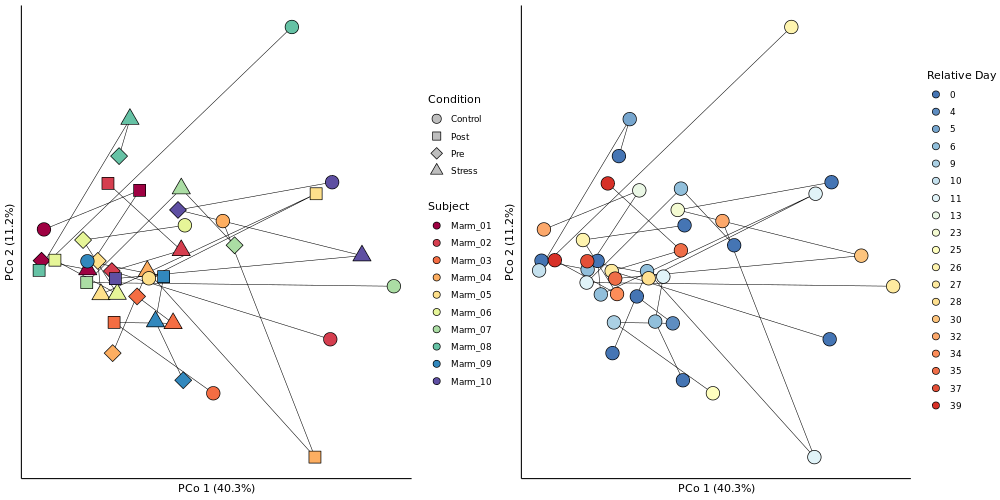

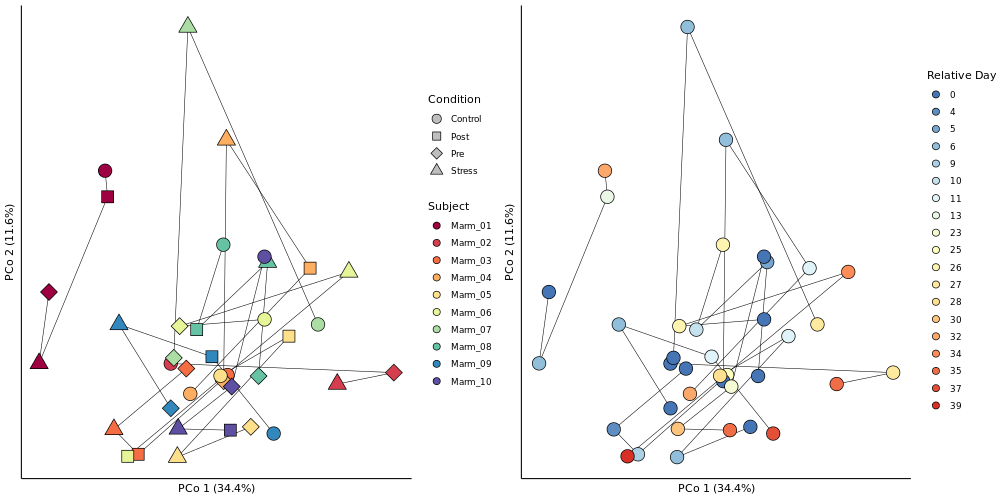

In [59]:
%%R -i sampleMeta,metabScaled,relativeGenera,targetedFeatureMeta -o metabRes,generaRes -w 1000 -h 500
figureDir <- '/common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome/analysis/figures'

sampleMeta$Relative_Day <- as.integer(sampleMeta$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaled, sampleMeta)
relGeneraDat <- convertDF(relativeGenera, sampleMeta)
targMetabDat$metaF <- targetedFeatureMeta

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0

for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized (doesn't make much difference as the data are already relative abundance data)
# and samples with all zeroes are dropped
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
genSums[genSums == 0] <- 1
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums
relGeneraDat.nrm$x <- relGeneraDat.nrm$x[rowSums(relGeneraDat.nrm$x) > 0,]
relGeneraDat.nrm$metaS <- relGeneraDat.nrm$metaS[rownames(relGeneraDat.nrm$x),]

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed, and microbiome data is arcsine square-root transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)
relGeneraDat.trans <- relGeneraDat
relGeneraDat.trans$x <- asin(sqrt(relGeneraDat.trans$x))

# PERMANOVA is run for metabolomics and genera abundance data. Zeros are used for filtered samples (n=2)
# because PERMANOVA required a balanced number of samples
# generaPerm <- runPerm(relGeneraDat)
# metabPerm <- runPerm(targMetabDat.nrm)
# print(generaPerm)
# print(metabPerm)

# Bray-Curtis distance matrix is calculated and a PCoA plot is created
metabPCoA <- PCoA(targMetabDat.nrm)
generaPCoA <- PCoA(relGeneraDat.nrm)

metabInd <- ordplot(targMetabDat.nrm, metabPCoA, colour="Anon_Individual", shape="Condition", connect="Anon_Individual", connectwidth=0.25, colour_title="Subject") +
    scale_fill_brewer(palette="Spectral")
metabDay <- ordplot(targMetabDat.nrm, metabPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
# metabCage <- ordplot(targMetabDat.nrm, metabPCoA,  shape="Sex", colour="Cage", connect="Anon_Individual", connectwidth=0.25) + scale_fill_brewer(palette="Set3")
# tgrob <- as_ggplot(text_grob("Bray-Curtis: Metabolomics", size = 20))
metabPlot <- ggarrange(metabInd, metabDay, ncol=2, nrow=1)
# metabPlot <- ggarrange(tgrob, metabPlot, nrow=2, heights=c(1, 10), labels='A', font.label=list(size=30))

plot(metabPlot)
ggsave('metabPCoA_stress.pdf', plot=metabPlot, device='pdf', path=figureDir, width=10, height=5, units='in')

generaInd <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Anon_Individual", shape="Condition", connect="Anon_Individual", connectwidth=0.25, colour_title="Subject") + 
    scale_fill_brewer(palette="Spectral")
generaDay <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
# generaCage <- ordplot(relGeneraDat.nrm, generaPCoA,  shape="Sex", colour="Cage", connect="Anon_Individual", connectwidth=0.25) + scale_fill_brewer(palette="Set3")
# tgrob <- as_ggplot(text_grob("Bray-Curtis: Genera Abundance", size = 20))
generaPlot <- ggarrange(generaInd, generaDay, ncol=2, nrow=1)
# generaPlot <- ggarrange(tgrob, generaPlot, nrow=2, heights=c(1, 10), labels='B', font.label=list(size=30))

plot(generaPlot)
ggsave('generaPCoA_stress.pdf', plot=generaPlot, device='pdf', path=figureDir, width=10, height=5, units='in')

# Metabolites and genera abundance data are fitted to a mixed model and their p-values/residuals are extracted
metabRes <- runMixedModel(targMetabDat.trans)
generaRes <- runMixedModel(relGeneraDat.trans)

In [17]:
# # Samples that were exposed to a stressful stimulus are removed from this analysis
sampleMetaNoStress = sampleMeta[sampleMeta['Condition'] != 'Stress']
metabScaledNoStress = metabScaled.loc[sampleMetaNoStress.index, :]
relativeGeneraNoStress = relativeGenera.loc[sampleMetaNoStress.index, :]

In [35]:
metabRes = dict(metabRes)
generaRes = dict(generaRes)
metabSig = metabRes['sig']
metabResid = metabRes['res']
generaSig = generaRes['sig']
generaResid = generaRes['res']

# metabSig
# metabSig.iloc[:, 3:] < 0.05
targetedFeatureMeta.loc[:, metabSig[metabSig.iloc[:, 3] < 0.05].index.values]
# metabSig[metabSig.iloc[:, 4:5] < 0.05]

,DKPMWHFRUGMUKF-GDYCBZMLSA-N,RFDAIACWWDREDC-FRVQLJSFSA-N,GHCZAUBVMUEKKP-GYPHWSFCSA-N,WVULKSPCQVQLCU-BUXLTGKBSA-N,WBWWGRHZICKQGZ-HZAMXZRMSA-N,AWDRATDZQPNJFN-VAYUFCLWSA-N,XOAAWQZATWQOTB-UHFFFAOYSA-N,AYFVYJQAPQTCCC-GBXIJSLDSA-N,KDXKERNSBIXSRK-YFKPBYRVSA-N
Sample_ID,,,,,,,,,
INCHIKEY,DKPMWHFRUGMUKF-GDYCBZMLSA-N,RFDAIACWWDREDC-FRVQLJSFSA-N,GHCZAUBVMUEKKP-GYPHWSFCSA-N,WVULKSPCQVQLCU-BUXLTGKBSA-N,WBWWGRHZICKQGZ-HZAMXZRMSA-N,AWDRATDZQPNJFN-VAYUFCLWSA-N,XOAAWQZATWQOTB-UHFFFAOYSA-N,AYFVYJQAPQTCCC-GBXIJSLDSA-N,KDXKERNSBIXSRK-YFKPBYRVSA-N
CID,5283852,10140,12544,3035026,6675,2733768,1123,6288,5962
Metabolite name,alpha-Muricholic acid,Glycocholic acid,Glycochenodeoxycholic acid,Glycodeoxycholic acid,Taurocholic acid,Taurodeoxycholic acid,Taurine,L-threonine,Lysine
Formula,C24H40O5,C26H43NO6,C26H43NO5,C26H43NO5,C26H45NO7S,C26H45NO6S,C2H7NO3S,C4H9NO3,C6H14N2O2
IUPACName,"(4R)-4-[(3R,5R,6S,7S,8S,9S,10R,13R,14S,17R)-3,...","2-[[(4R)-4-[(3R,5S,7R,8R,9S,10S,12S,13R,14S,17...","2-[[(4R)-4-[(3R,5S,7R,8R,9S,10S,13R,14S,17R)-3...","2-[[(4R)-4-[(3R,5R,8R,9S,10S,12S,13R,14S,17R)-...","2-[[(4R)-4-[(3R,5S,7R,8R,9S,10S,12S,13R,14S,17...","2-[[(4R)-4-[(3R,5R,8R,9S,10S,12S,13R,14S,17R)-...",2-aminoethanesulfonic acid,"(2S,3R)-2-amino-3-hydroxybutanoic acid","(2S)-2,6-diaminohexanoic acid"
Method,LC-MS,LC-MS,LC-MS,LC-MS,LC-MS,LC-MS,HPLC,HPLC,HPLC
Dataset,bile_acids,bile_acids,bile_acids,bile_acids,bile_acids,bile_acids,amino_acids,amino_acids,amino_acids


R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-2

R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

R[write to console]: This is labdsv 2.0-1
convert existing ordinations with as.dsvord()

R[write to console]: 
Attaching package: ‘labdsv’


R[write to console]: The following object is masked from ‘package:stats’:

    density


R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

R[write to console]: Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lme4’


R[write to console]: The following object is masked from ‘

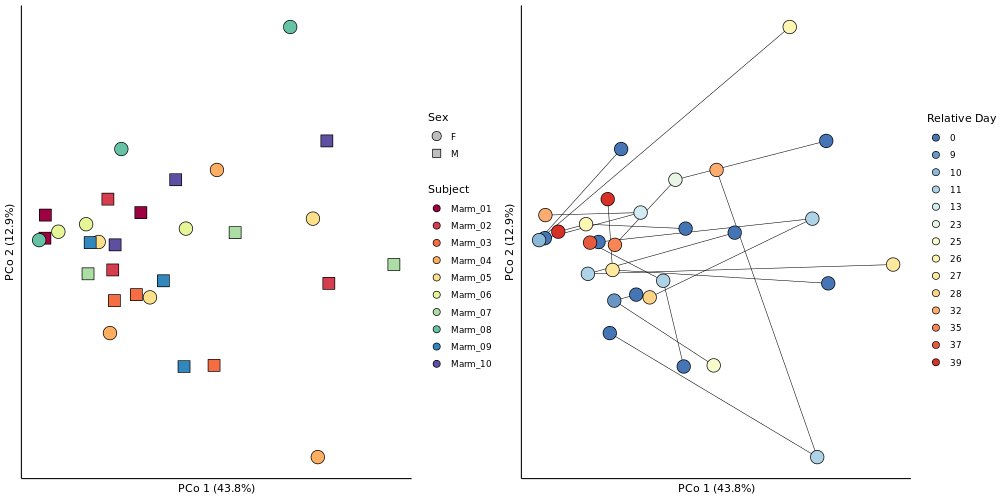

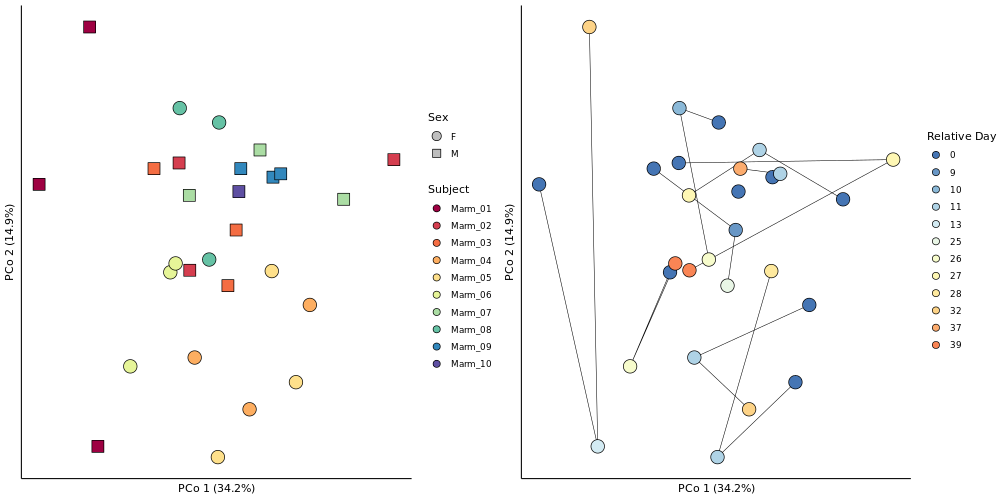

In [16]:
%%R -i sampleMetaNoStress,metabScaledNoStress,relativeGeneraNoStress,targetedFeatureMeta -o targMetabRes,relGeneraRes -w 1000 -h 500
figureDir <- '/common/claytonlab/jhernandez/projects/final_marm_microbiome_metabolome/analysis/figures'
# -w and -h control the height and width, respectively, that R uses to render images: https://ipython.org/ipython-doc/2/config/extensions/rmagic.html
### Ordination ###


# From huttenhower source code:
# The species were first sum normalized with the generic pcl.norm, then put through the pcl.pcoa function.
# Metabolites were normalized within method before the pcl.pcoa was applied:
# https://bitbucket.org/biobakery/hmp2_analysis/src/master/overview/src/subject_timeseries.r
# https://bitbucket.org/biobakery/hmp2_analysis/src/master/common/pcl_utils.r
sampleMetaNoStress$Relative_Day <- as.integer(sampleMetaNoStress$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaledNoStress, sampleMetaNoStress)
relGeneraDat <- convertDF(relativeGeneraNoStress, sampleMetaNoStress)
targMetabDat$metaF <- targetedFeatureMeta

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0
for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized and samples with all zeroes are dropped
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
genSums[genSums == 0] <- 1
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums
relGeneraDat.nrm$x <- relGeneraDat.nrm$x[rowSums(relGeneraDat.nrm$x) > 0,]

# Bray-Curtis distance matrix is calculated and a PCoA plot is created
metabPCoA <- PCoA(targMetabDat.nrm)
generaPCoA <- PCoA(relGeneraDat.nrm)
     
metabInd <- ordplot(targMetabDat.nrm, metabPCoA, colour="Anon_Individual", shape="Sex", colour_title="Subject") + scale_fill_brewer(palette="Spectral")
metabDay <- ordplot(targMetabDat.nrm, metabPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
# tgrob <- as_ggplot(text_grob("Bray-Curtis: Metabolomics", size = 20))
metabPlot <- ggarrange(metabInd, metabDay, ncol=2, nrow=1)
# metabPlot <- ggarrange(tgrob, metabPlot, nrow=2, heights=c(1, 10), labels='A', font.label=list(size=30))

plot(metabPlot)
# ggsave('metabPCoA.pdf', plot=metabPlot, device='pdf', path=figureDir, width=10, height=5, units='in')
ggsave('metabPCoA.tiff', plot=metabPlot, device='tiff', path=figureDir, width=10, height=5, units='in', dpi=300)

generaInd <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Anon_Individual", shape="Sex", colour_title="Subject") + scale_fill_brewer(palette="Spectral")
generaDay <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
# tgrob <- as_ggplot(text_grob("Bray-Curtis: Genera Abundance", size = 20))
generaPlot <- ggarrange(generaInd, generaDay, ncol=2, nrow=1)
# generaPlot <- ggarrange(tgrob, generaPlot, nrow=2, heights=c(1, 10), labels='B', font.label=list(size=30))

plot(generaPlot)
# ggsave('generaPCoA.pdf', plot=generaPlot, device='pdf', path=figureDir, width=10, height=5, units='in')
ggsave('generaPCoA.tiff', plot=generaPlot, device='tiff', path=figureDir, width=10, height=5, units='in', dpi=300)

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed, and microbiome data is arcsine square-root transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)
relGeneraDat.trans <- relGeneraDat
relGeneraDat.trans$x <- asin(sqrt(relGeneraDat.trans$x))



# The transformed data are fit to a linear model and the residuals are extracted for downstream correlation analysis
targMetabRes <- runFixedModel(targMetabDat.trans)
relGeneraRes <- runFixedModel(relGeneraDat.trans)
# print(metabInd$legend)
# print(?as_ggplot)

In [202]:
### Saving Residuals and Creation of Node Properties Table ###

# Residuals are written to a new directory 
resDir = analysisDir.joinpath('fitted_residuals')
if not resDir.exists():
    resDir.mkdir()

targMetabRes.T.to_csv(resDir.joinpath('targeted_metabolites.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraRes.T.to_csv(resDir.joinpath('relative_genera.tsv'), sep='\t', index=True, index_label='Sample_ID')

# The node properties table is created and saved for use in Cytoscape
nodeKeyToProperties = {}
targetedFeatureMeta.apply(lambda x: nodeKeyToProperties.update({x['INCHIKEY']: [x['Metabolite name'], x['Dataset'], 'metabolite']}))

pat = re.compile('^.*f__([^;]+);g_(.+)$')
[nodeKeyToProperties.update({col: [''.join(pat.match(col).groups(0)), pat.match(col).group(1), 'microbe',]}) for col in relativeGeneraNoStress.columns]
nodeProperties = pd.DataFrame(nodeKeyToProperties).T.reset_index().rename(columns={'index': 'key', 0: 'common_name', 1: 'parent_group', 2: 'type'})
nodeProperties.to_csv('node_properties.tsv', sep='\t', index=False)

# Residual column names are replaced with common names for pretty halla output
targMetabCommonName = targMetabRes.copy()
relGeneraCommonName = relGeneraRes.copy()
targMetabCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in targMetabCommonName.columns]
relGeneraCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in relGeneraCommonName.columns]
targMetabCommonName.T.to_csv(resDir.joinpath('targeted_metabolites_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraCommonName.T.to_csv(resDir.joinpath('relative_genera_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

for dset in targetedFeatureMeta.loc['Dataset'].unique():
    dsetRes = targMetabRes.loc[:, targetedFeatureMeta.loc['Dataset'] == dset]
    dsetRes.T.to_csv(resDir.joinpath(dset + '.tsv'), sep='\t', index=True, index_label='Sample_ID')
    dsetResCommonName = dsetRes.copy()
    dsetResCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in dsetResCommonName.columns]
    dsetResCommonName.T.to_csv(resDir.joinpath(dset + '_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

In [30]:
!halla --help
# !hallagram --help

usage: halla [-h] -x X_FILE [-y Y_FILE] [--alla]
             [--max_freq_thresh MAX_FREQ_THRESH]
             [--transform_data_funcs TRANSFORM_DATA_FUNCS [TRANSFORM_DATA_FUNCS ...]]
             [--disable_bypass_discretization_if_possible]
             [--discretize_func {None,quantile,kmeans,uniform,jenks}]
             [--discretize_num_bins DISCRETIZE_NUM_BINS]
             [-m {spearman,pearson,dcor,mi,nmi,xicor}]
             [--sim2dist_disable_abs] [--linkage_method LINKAGE_METHOD]
             [--permute_func {gpd,ecdf}] [--permute_iters PERMUTE_ITERS]
             [--disable_permute_speedup] [--fdr_alpha FDR_ALPHA]
             [--fdr_method FDR_METHOD] [--fnr_thresh FNR_THRESH]
             [--rank_cluster {best,average}] -o OUT_DIR [--disable_verbose]
             [--seed SEED] [--hallagram] [--no_hallagram] [--clustermap]
             [--x_dataset_label X_DATASET_LABEL]
             [--y_dataset_label Y_DATASET_LABEL] [--cbar_label CBAR_LABEL]
             [-n BLOCK_NUM]

In [203]:
%%bash -s "$resDir"
residualDir=$1

# Halla ((hierarchical all-against-all association testing) is performed against all feature pairs.
# Alla, the non-hierarchical variant of Halla, is used for within-dataset associations, while Halla is used for between-dataset associations.
if [[ -d halla_output ]]; then
    rm -r halla_output
fi

mkdir -p halla_output/{metab_dsets_combined,metab_dsets_separate}/{non_graphical_output,graphical_output}

declare -a dsets=("amino_acids" "bile_acids" "short_chain_fatty_acids")

# Non-graphical halla output has INCHIKEYS/Full microbe taxa for column names and is used for downstream Cytoscape analysis.
# Graphical halla output has common metabolite names and shortened taxa as column names and is used for generation of a hallagram
hallaDir="halla_output/metab_dsets_combined/non_graphical_output"
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/targeted_metabolites.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --alla --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/relative_genera.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --alla --no_hallagram --dont_copy --disable_verbose

hallaDir="halla_output/metab_dsets_combined/graphical_output"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --clustermap --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-genera"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/targeted_metabolites_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-metabolite" --suppress_numbers
halla -x "${residualDir}/relative_genera_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/genera-genera" --suppress_numbers


for residuals in "${dsets[@]}"; do
    hallaDir="halla_output/metab_dsets_separate/non_graphical_output"
    halla -x "${residualDir}/${residuals}.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-genera" --no_hallagram --dont_copy --disable_verbose  
    halla -x "${residualDir}/${residuals}.tsv" -y  "${residualDir}/${residuals}.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-${residuals}" --alla --no_hallagram --dont_copy --disable_verbose
    
    hallaDir="halla_output/metab_dsets_separate/graphical_output"
    halla -x "${residualDir}/${residuals}_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-genera" --clustermap --disable_verbose --no_hallagram
    hallagram -i "${hallaDir}/${residuals}-genera"
    halla -x "${residualDir}/${residuals}_common_name.tsv" -y  "${residualDir}/${residuals}_common_name.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-${residuals}" --alla --disable_verbose --no_hallagram
    hallagram -i "${hallaDir}/${residuals}-${residuals}" --suppress_numbers
done

100%|██████████| 4/4 [00:00<00:00, 367.73it/s]


In [204]:
### Aggregation of Halla Output ###
hallaOutput = pathlib.Path('halla_output/metab_dsets_combined/non_graphical_output')
pat = re.compile('^.+\/(.+)-(.+)$')
qValCutoff = 0.05

# All associations are aggregated and saved in one file
with open('associations.tsv', 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features']) & (associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.loc[(associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)

In [205]:
### Comparison of Combined and Separate Metabolite Associations ###
hallaOutput = pathlib.Path('halla_output/metab_dsets_combined/non_graphical_output')
pat = re.compile('^.+\/(.+)-(.+)$')

# All associations are aggregated and saved in one file
with open('comb_associations.tsv', 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features'])].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
            
hallaOutput = pathlib.Path('halla_output/metab_dsets_separate/non_graphical_output')

# All associations are aggregated and saved in one file
with open('sep_associations.tsv', 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features'])].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
    
combAssoc = pd.read_csv('comb_associations.tsv', sep='\t')
sepAssoc = pd.read_csv('sep_associations.tsv', sep='\t')

print(combAssoc.shape)
print(sepAssoc.shape)
comparedAssoc = combAssoc.merge(sepAssoc, left_on=['X_features', 'Y_features'], right_on=['X_features', 'Y_features'], suffixes=['_comb', '_sep'])
comparedAssoc.to_csv('compared_associations.tsv', sep='\t', index=False, header=True)
print('Max association difference: ' + (comparedAssoc['association_comb'] - comparedAssoc['association_sep']).max().astype(str))
print('Max p-value difference: ' + (comparedAssoc['p-values_comb'] - comparedAssoc['p-values_sep']).max().astype(str))
print('Max q-value difference: ' + (comparedAssoc['q-values_comb'] - comparedAssoc['q-values_sep']).max().astype(str))

pathlib.Path('comb_associations.tsv').unlink()
pathlib.Path('sep_associations.tsv').unlink()

(4465, 6)
(2491, 6)
Max association difference: 0.0
Max p-value difference: 0.0
Max q-value difference: 0.10584649302809623
